/var/folders/xp/71sphh4j5lg02zrcgkfdzpwr0000gn/T/ipykernel_57655/1844900309.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start="2019-01-01", end="2024-10-31")
[*********************100%***********************]  3 of 3 completed


            Close_AAPL  Close_AMZN  Close_MSFT  High_AAPL  High_AMZN  \
Date                                                                   
2019-01-30   39.281212   83.521500   99.534103  39.495147  83.847504   
2019-01-31   39.564079   85.936501   97.709610  40.172611  86.820503   
2019-02-01   39.583103   81.311501   96.165779  40.167862  83.653000   
2019-02-04   40.707451   81.665497   98.935287  40.804912  82.481499   
2019-02-05   41.403931   82.940498  100.320045  41.617870  83.263000   

             High_MSFT   Low_AAPL   Low_AMZN   Low_MSFT  Open_AAPL  ...  \
Date                                                                ...   
2019-01-30   99.534103  38.087918  80.984001  97.616032  38.805796  ...   
2019-01-31   98.448772  39.117188  83.954002  96.540051  39.485635  ...   
2019-02-01   97.400833  39.442853  81.100502  95.763451  39.687695  ...   
2019-02-04   98.991431  39.763751  80.675003  96.156415  39.794654  ...   
2019-02-05  100.366824  40.968929  82.125000 

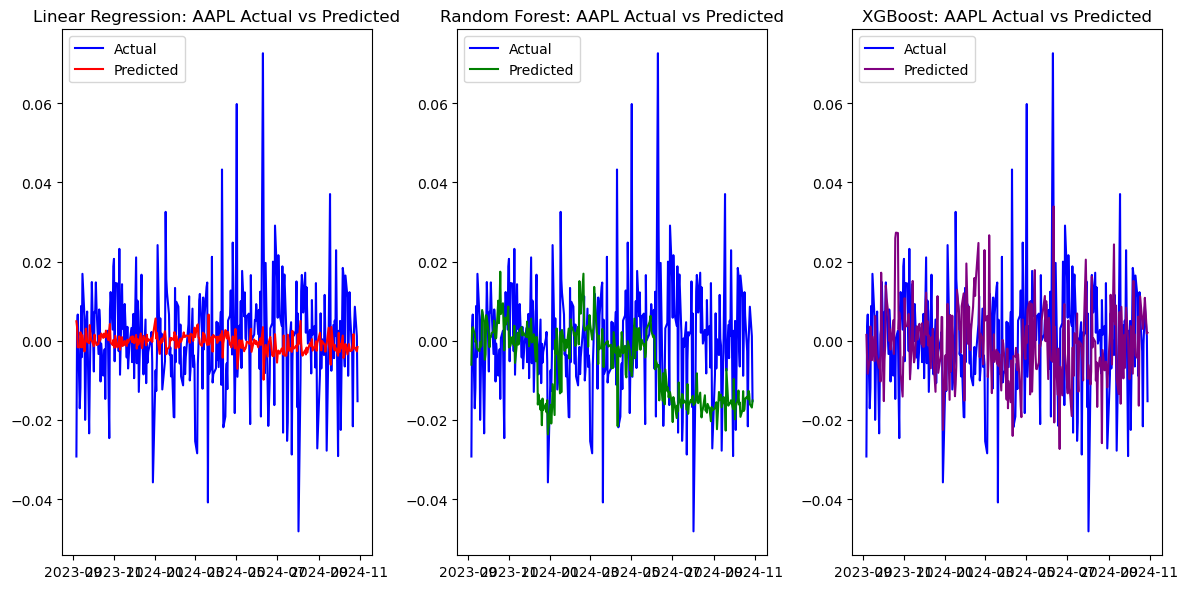

Evaluating for MSFT...
Linear Regression RMSE for MSFT: 0.012441226292137493
Linear Regression MAE for MSFT: 0.009718527208028519
Random Forest RMSE for MSFT: 0.013665511412042952
Random Forest MAE for MSFT: 0.010881171092069986
XGBoost RMSE for MSFT: 0.017412407512005817
XGBoost MAE for MSFT: 0.014094331432047823


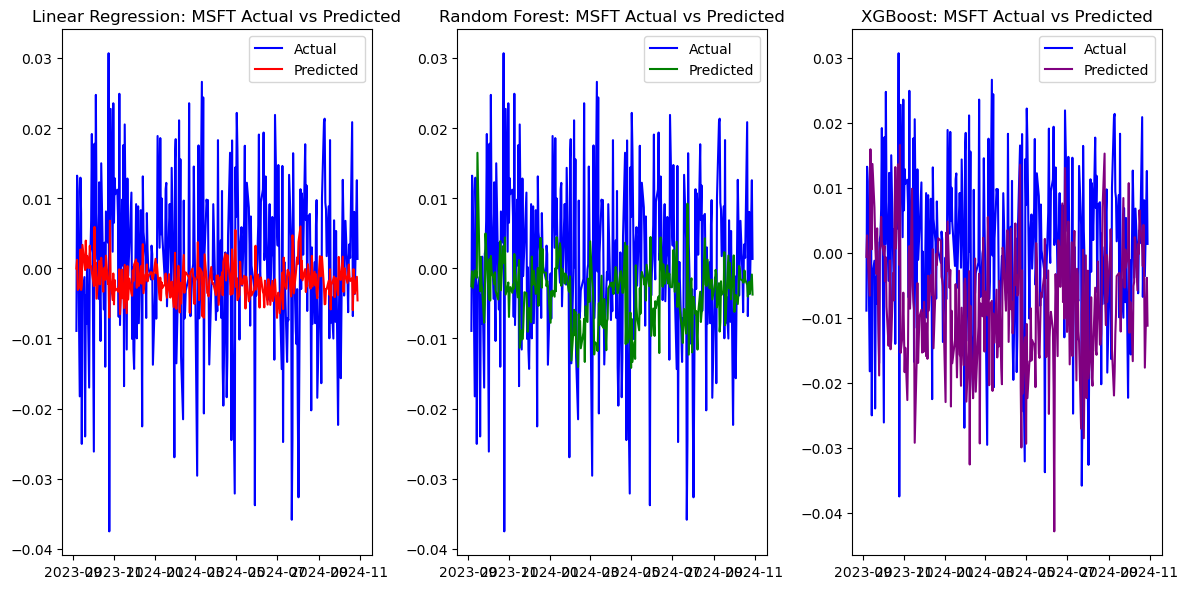

Evaluating for AMZN...
Linear Regression RMSE for AMZN: 0.0176882987241732
Linear Regression MAE for AMZN: 0.013000352342169742
Random Forest RMSE for AMZN: 0.030753884036328206
Random Forest MAE for AMZN: 0.024467415366821534
XGBoost RMSE for AMZN: 0.022180208996746446
XGBoost MAE for AMZN: 0.016583395499756515


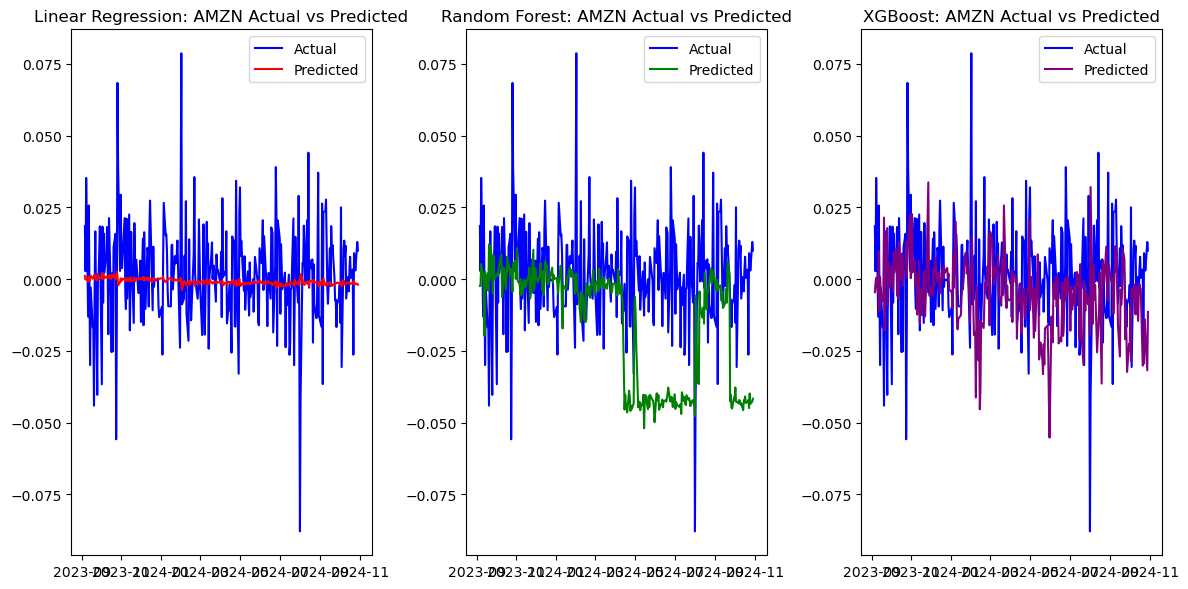

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest RMSE (AAPL): 0.01648085356398394
Best Random Forest MAE (AAPL): 0.012784458518384105


In [35]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Step 1: Download stock data for AAPL, MSFT, and AMZN
stocks = ['AAPL', 'MSFT', 'AMZN']
data = yf.download(stocks, start="2019-01-01", end="2024-10-31")

# Flatten MultiIndex columns
data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Step 2: Feature Engineering - Calculate returns, moving averages, volatility, etc.
# Calculate daily returns
data['Return_1d_AAPL'] = data['Close_AAPL'].pct_change()
data['Return_1d_MSFT'] = data['Close_MSFT'].pct_change()
data['Return_1d_AMZN'] = data['Close_AMZN'].pct_change()

# Calculate 10-day moving average (MA10)
data['MA10_AAPL'] = data['Close_AAPL'].rolling(window=10).mean()
data['MA10_MSFT'] = data['Close_MSFT'].rolling(window=10).mean()
data['MA10_AMZN'] = data['Close_AMZN'].rolling(window=10).mean()

# Calculate 20-day moving average (MA20)
data['MA20_AAPL'] = data['Close_AAPL'].rolling(window=20).mean()
data['MA20_MSFT'] = data['Close_MSFT'].rolling(window=20).mean()
data['MA20_AMZN'] = data['Close_AMZN'].rolling(window=20).mean()

# Calculate 5-day return
data['Return_5d_AAPL'] = data['Close_AAPL'].pct_change(5)
data['Return_5d_MSFT'] = data['Close_MSFT'].pct_change(5)
data['Return_5d_AMZN'] = data['Close_AMZN'].pct_change(5)

# Calculate 10-day volatility (standard deviation)
data['Volatility_AAPL'] = data['Return_1d_AAPL'].rolling(window=10).std()
data['Volatility_MSFT'] = data['Return_1d_MSFT'].rolling(window=10).std()
data['Volatility_AMZN'] = data['Return_1d_AMZN'].rolling(window=10).std()

# Calculate volume change (percentage change in volume)
data['Volume_change_AAPL'] = data['Volume_AAPL'].pct_change()
data['Volume_change_MSFT'] = data['Volume_MSFT'].pct_change()
data['Volume_change_AMZN'] = data['Volume_AMZN'].pct_change()

# Drop rows with missing values (due to rolling operations)
data = data.dropna()

# Ensure the Date index is in datetime format
data.index = pd.to_datetime(data.index)

# Display the cleaned data (check for correctness)
print(data.head())

# Step 3: Train-Test Split for AAPL, MSFT, and AMZN (time-series, no shuffling)

def train_test_split_time_series(data, stock_symbol):
    X = data[['Return_1d_' + stock_symbol, 'Return_5d_' + stock_symbol, 
              'MA10_' + stock_symbol, 'MA20_' + stock_symbol, 
              'Volatility_' + stock_symbol, 'Volume_change_' + stock_symbol]]
    y = data['Return_1d_' + stock_symbol].shift(-1)  # Next day's return (shifted by 1)

    # Remove the last row with NaN values created by the shift
    X = X[:-1]
    y = y.dropna()

    # Train-test split (time-series, no shuffling)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    return X_train, X_test, y_train, y_test

# Apply train-test split for each stock
X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL = train_test_split_time_series(data, 'AAPL')
X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT = train_test_split_time_series(data, 'MSFT')
X_train_AMZN, X_test_AMZN, y_train_AMZN, y_test_AMZN = train_test_split_time_series(data, 'AMZN')

# Step 4: Train Linear Regression Model for AAPL
def linear_regression(X_train, X_test, y_train, y_test):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred_lr = lr_model.predict(X_test)

    # Evaluate model performance using RMSE and MAE
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    mae_lr = mean_absolute_error(y_test, y_pred_lr)

    return rmse_lr, mae_lr, y_pred_lr

# Step 5: Train Random Forest Model for AAPL
def random_forest(X_train, X_test, y_train, y_test):
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = rf_model.predict(X_test)

    # Evaluate model performance using RMSE and MAE
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mae_rf = mean_absolute_error(y_test, y_pred_rf)

    return rmse_rf, mae_rf, y_pred_rf

# Step 6: Train XGBoost Model for AAPL
def xgboost_model(X_train, X_test, y_train, y_test):
    xg_model = xgb.XGBRegressor(n_estimators=200, random_state=42)
    xg_model.fit(X_train, y_train)

    # Make predictions
    y_pred_xgb = xg_model.predict(X_test)

    # Evaluate model performance using RMSE and MAE
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

    return rmse_xgb, mae_xgb, y_pred_xgb

# Evaluate models for each stock (AAPL, MSFT, AMZN)
stocks = ['AAPL', 'MSFT', 'AMZN']

for stock in stocks:
    print(f"Evaluating for {stock}...")

    # Linear Regression
    if stock == 'AAPL':
        X_train, X_test, y_train, y_test = X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL
    elif stock == 'MSFT':
        X_train, X_test, y_train, y_test = X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT
    else:
        X_train, X_test, y_train, y_test = X_train_AMZN, X_test_AMZN, y_train_AMZN, y_test_AMZN

    rmse_lr, mae_lr, y_pred_lr = linear_regression(X_train, X_test, y_train, y_test)
    rmse_rf, mae_rf, y_pred_rf = random_forest(X_train, X_test, y_train, y_test)
    rmse_xgb, mae_xgb, y_pred_xgb = xgboost_model(X_train, X_test, y_train, y_test)

    # Print Evaluation Results
    print(f"Linear Regression RMSE for {stock}: {rmse_lr}")
    print(f"Linear Regression MAE for {stock}: {mae_lr}")
    print(f"Random Forest RMSE for {stock}: {rmse_rf}")
    print(f"Random Forest MAE for {stock}: {mae_rf}")
    print(f"XGBoost RMSE for {stock}: {rmse_xgb}")
    print(f"XGBoost MAE for {stock}: {mae_xgb}")

    # Step 7: Visualizing Actual vs Predicted Returns for Each Model
    plt.figure(figsize=(12, 6))

    # Linear Regression Plot
    plt.subplot(1, 3, 1)
    plt.plot(y_test.index, y_test, label="Actual", color="blue")
    plt.plot(y_test.index, y_pred_lr, label="Predicted", color="red")
    plt.title(f"Linear Regression: {stock} Actual vs Predicted")
    plt.legend()

    # Random Forest Plot
    plt.subplot(1, 3, 2)
    plt.plot(y_test.index, y_test, label="Actual", color="blue")
    plt.plot(y_test.index, y_pred_rf, label="Predicted", color="green")
    plt.title(f"Random Forest: {stock} Actual vs Predicted")
    plt.legend()

    # XGBoost Plot
    plt.subplot(1, 3, 3)
    plt.plot(y_test.index, y_test, label="Actual", color="blue")
    plt.plot(y_test.index, y_pred_xgb, label="Predicted", color="purple")
    plt.title(f"XGBoost: {stock} Actual vs Predicted")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 8: Hyperparameter Tuning for Random Forest using GridSearchCV (for one stock)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_AAPL, y_train_AAPL)

# Best parameters from GridSearchCV
print("Best Random Forest Parameters:", grid_search.best_params_)

# Evaluate the best model
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_AAPL)

# Evaluate performance
rmse_best_rf = np.sqrt(mean_squared_error(y_test_AAPL, y_pred_best_rf))
mae_best_rf = mean_absolute_error(y_test_AAPL, y_pred_best_rf)

print(f"Best Random Forest RMSE (AAPL): {rmse_best_rf}")
print(f"Best Random Forest MAE (AAPL): {mae_best_rf}")


/var/folders/xp/71sphh4j5lg02zrcgkfdzpwr0000gn/T/ipykernel_57655/2818862795.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start="2019-01-01", end="2024-10-31")
[*********************100%***********************]  3 of 3 completed


Evaluating for AAPL...
Linear Regression RMSE for AAPL: 0.014260922321835495
Linear Regression MAE for AAPL: 0.010628162264075447
Random Forest RMSE for AAPL: 0.01770876005754087
Random Forest MAE for AAPL: 0.013849369812202219
XGBoost RMSE for AAPL: 0.016474772630095197
XGBoost MAE for AAPL: 0.01282596787537522
Evaluating for MSFT...
Linear Regression RMSE for MSFT: 0.012441226292137493
Linear Regression MAE for MSFT: 0.009718527208028519
Random Forest RMSE for MSFT: 0.013665511412042952
Random Forest MAE for MSFT: 0.010881171092069986
XGBoost RMSE for MSFT: 0.017412407512005817
XGBoost MAE for MSFT: 0.014094331432047823
Evaluating for AMZN...
Linear Regression RMSE for AMZN: 0.0176882987241732
Linear Regression MAE for AMZN: 0.013000352342169742
Random Forest RMSE for AMZN: 0.030753884036328206
Random Forest MAE for AMZN: 0.024467415366821534
XGBoost RMSE for AMZN: 0.022180208996746446
XGBoost MAE for AMZN: 0.016583395499756515


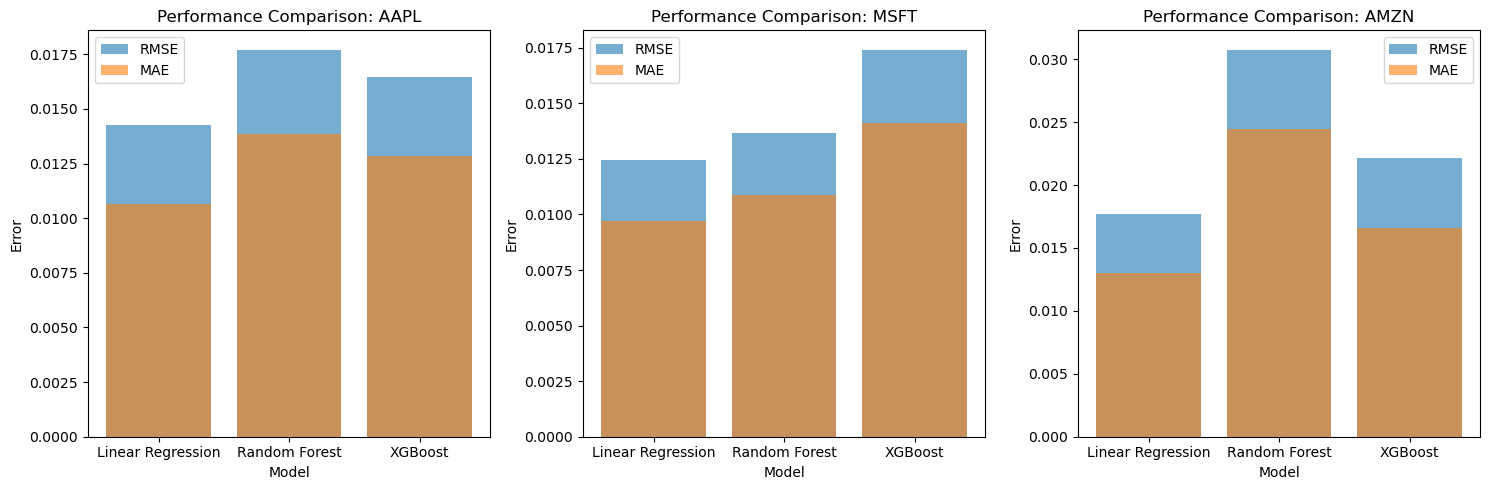

In [36]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Step 1: Download stock data for AAPL, MSFT, and AMZN
stocks = ['AAPL', 'MSFT', 'AMZN']
data = yf.download(stocks, start="2019-01-01", end="2024-10-31")

# Flatten MultiIndex columns
data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Step 2: Feature Engineering - Calculate returns, moving averages, volatility, etc.
# Calculate daily returns
data['Return_1d_AAPL'] = data['Close_AAPL'].pct_change()
data['Return_1d_MSFT'] = data['Close_MSFT'].pct_change()
data['Return_1d_AMZN'] = data['Close_AMZN'].pct_change()

# Calculate 10-day moving average (MA10)
data['MA10_AAPL'] = data['Close_AAPL'].rolling(window=10).mean()
data['MA10_MSFT'] = data['Close_MSFT'].rolling(window=10).mean()
data['MA10_AMZN'] = data['Close_AMZN'].rolling(window=10).mean()

# Calculate 20-day moving average (MA20)
data['MA20_AAPL'] = data['Close_AAPL'].rolling(window=20).mean()
data['MA20_MSFT'] = data['Close_MSFT'].rolling(window=20).mean()
data['MA20_AMZN'] = data['Close_AMZN'].rolling(window=20).mean()

# Calculate 5-day return
data['Return_5d_AAPL'] = data['Close_AAPL'].pct_change(5)
data['Return_5d_MSFT'] = data['Close_MSFT'].pct_change(5)
data['Return_5d_AMZN'] = data['Close_AMZN'].pct_change(5)

# Calculate 10-day volatility (standard deviation)
data['Volatility_AAPL'] = data['Return_1d_AAPL'].rolling(window=10).std()
data['Volatility_MSFT'] = data['Return_1d_MSFT'].rolling(window=10).std()
data['Volatility_AMZN'] = data['Return_1d_AMZN'].rolling(window=10).std()

# Calculate volume change (percentage change in volume)
data['Volume_change_AAPL'] = data['Volume_AAPL'].pct_change()
data['Volume_change_MSFT'] = data['Volume_MSFT'].pct_change()
data['Volume_change_AMZN'] = data['Volume_AMZN'].pct_change()

# Drop rows with missing values (due to rolling operations)
data = data.dropna()

# Ensure the Date index is in datetime format
data.index = pd.to_datetime(data.index)

# Step 3: Train-Test Split for AAPL, MSFT, and AMZN (time-series, no shuffling)

def train_test_split_time_series(data, stock_symbol):
    X = data[['Return_1d_' + stock_symbol, 'Return_5d_' + stock_symbol, 
              'MA10_' + stock_symbol, 'MA20_' + stock_symbol, 
              'Volatility_' + stock_symbol, 'Volume_change_' + stock_symbol]]
    y = data['Return_1d_' + stock_symbol].shift(-1)  # Next day's return (shifted by 1)

    # Remove the last row with NaN values created by the shift
    X = X[:-1]
    y = y.dropna()

    # Train-test split (time-series, no shuffling)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    return X_train, X_test, y_train, y_test

# Apply train-test split for each stock
X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL = train_test_split_time_series(data, 'AAPL')
X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT = train_test_split_time_series(data, 'MSFT')
X_train_AMZN, X_test_AMZN, y_train_AMZN, y_test_AMZN = train_test_split_time_series(data, 'AMZN')

# Step 4: Train Linear Regression Model for AAPL, MSFT, and AMZN
def linear_regression(X_train, X_test, y_train, y_test):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred_lr = lr_model.predict(X_test)

    # Evaluate model performance using RMSE and MAE
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    mae_lr = mean_absolute_error(y_test, y_pred_lr)

    return rmse_lr, mae_lr, y_pred_lr

# Step 5: Train Random Forest Model for AAPL, MSFT, and AMZN
def random_forest(X_train, X_test, y_train, y_test):
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = rf_model.predict(X_test)

    # Evaluate model performance using RMSE and MAE
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mae_rf = mean_absolute_error(y_test, y_pred_rf)

    return rmse_rf, mae_rf, y_pred_rf

# Step 6: Train XGBoost Model for AAPL, MSFT, and AMZN
def xgboost_model(X_train, X_test, y_train, y_test):
    xg_model = xgb.XGBRegressor(n_estimators=200, random_state=42)
    xg_model.fit(X_train, y_train)

    # Make predictions
    y_pred_xgb = xg_model.predict(X_test)

    # Evaluate model performance using RMSE and MAE
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

    return rmse_xgb, mae_xgb, y_pred_xgb

# Evaluate models for each stock (AAPL, MSFT, AMZN)
stocks = ['AAPL', 'MSFT', 'AMZN']
results = {'Model': [], 'Stock': [], 'RMSE': [], 'MAE': []}

for stock in stocks:
    print(f"Evaluating for {stock}...")

    # Linear Regression
    if stock == 'AAPL':
        X_train, X_test, y_train, y_test = X_train_AAPL, X_test_AAPL, y_train_AAPL, y_test_AAPL
    elif stock == 'MSFT':
        X_train, X_test, y_train, y_test = X_train_MSFT, X_test_MSFT, y_train_MSFT, y_test_MSFT
    else:
        X_train, X_test, y_train, y_test = X_train_AMZN, X_test_AMZN, y_train_AMZN, y_test_AMZN

    rmse_lr, mae_lr, y_pred_lr = linear_regression(X_train, X_test, y_train, y_test)
    rmse_rf, mae_rf, y_pred_rf = random_forest(X_train, X_test, y_train, y_test)
    rmse_xgb, mae_xgb, y_pred_xgb = xgboost_model(X_train, X_test, y_train, y_test)

    # Store results for comparison
    results['Model'].extend(['Linear Regression', 'Random Forest', 'XGBoost'])
    results['Stock'].extend([stock] * 3)
    results['RMSE'].extend([rmse_lr, rmse_rf, rmse_xgb])
    results['MAE'].extend([mae_lr, mae_rf, mae_xgb])

    # Print evaluation results for each model
    print(f"Linear Regression RMSE for {stock}: {rmse_lr}")
    print(f"Linear Regression MAE for {stock}: {mae_lr}")
    print(f"Random Forest RMSE for {stock}: {rmse_rf}")
    print(f"Random Forest MAE for {stock}: {mae_rf}")
    print(f"XGBoost RMSE for {stock}: {rmse_xgb}")
    print(f"XGBoost MAE for {stock}: {mae_xgb}")

# Step 7: Model Performance Comparison - Visualizing the results for each stock
df_results = pd.DataFrame(results)

# Create subplots for each stock's comparison
plt.figure(figsize=(15, 5))

for i, stock in enumerate(stocks):
    stock_data = df_results[df_results['Stock'] == stock]
    plt.subplot(1, 3, i+1)
    plt.bar(stock_data['Model'], stock_data['RMSE'], label="RMSE", alpha=0.6)
    plt.bar(stock_data['Model'], stock_data['MAE'], label="MAE", alpha=0.6)
    plt.title(f"Performance Comparison: {stock}")
    plt.xlabel("Model")
    plt.ylabel("Error")
    plt.legend()

plt.tight_layout()
plt.show()
